In [64]:
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.nn import Sequential as Sq
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.autograd as autograd
import argparse


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


class SwissRoll(torch.utils.data.Dataset):
    def __init__(self, n_samples=100000, noise=0.5):
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.5)[0][:,[0, 2]]
        xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
        x = (x - xmin) / (xmax - xmin)
        self.x = torch.FloatTensor(2. * x - 1.)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [65]:
class Score(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=256):
        super().__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim

        self.net = Sq(nn.Linear(x_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, x_dim))

    def forward(self, x):
        return self.net(x)

In [66]:
dataset = SwissRoll()
score = Score()
optimizer = optim.Adam(score.parameters(), lr=1e-3)
loss_meter = AverageMeter()

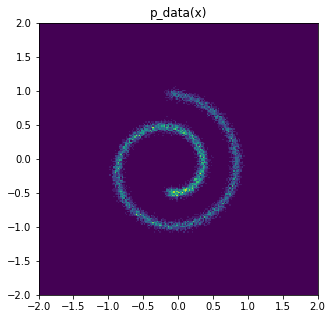

In [73]:
plt.figure(figsize=(5, 5))
plt.title('p_data(x)')
plt.hist2d(dataset.x[:10000,0].numpy(), dataset.x[:10000,1].numpy(), 200, range=((-2, 2), (-2, 2)))
plt.show()

In [67]:
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

for epoch in range(20):
    loss_meter.reset()
    for x in loader:
        x.requires_grad_(True)
        x1, x2 = x.chunk(2, -1)
        x = torch.cat([x1, x2], -1)
        optimizer.zero_grad()
        s1, s2 = score(x).chunk(2, -1)
        
        term1 = 0.5 * (s1.square() + s2.square())
        trace1 = autograd.grad(outputs=s1,
                               inputs=x1,
                               grad_outputs=torch.ones_like(s1),
                               create_graph=True)[0]
        
        trace2 = autograd.grad(outputs=s2,
                               inputs=x2,
                               grad_outputs=torch.ones_like(s2),
                               create_graph=True)[0]
        
        loss = term1 + trace1 + trace2
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
    print('[epoch %3d] | %s: %7.5f' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: -198.91264
[epoch   1] | loss: -292.91875
[epoch   2] | loss: -303.99601
[epoch   3] | loss: -307.33917
[epoch   4] | loss: -312.95971
[epoch   5] | loss: -314.51666
[epoch   6] | loss: -316.33855
[epoch   7] | loss: -318.77040
[epoch   8] | loss: -319.55351
[epoch   9] | loss: -318.98139
[epoch  10] | loss: -320.08380
[epoch  11] | loss: -321.60532
[epoch  12] | loss: -321.50799
[epoch  13] | loss: -321.39034
[epoch  14] | loss: -321.86617
[epoch  15] | loss: -322.92248
[epoch  16] | loss: -323.47348
[epoch  17] | loss: -323.73225
[epoch  18] | loss: -325.53145
[epoch  19] | loss: -325.03505


In [68]:
@torch.no_grad()
def langevin_dynamics(x, score, num_steps=1000, dt=0.01):
    dt = torch.tensor([dt]).to(x.device)
    for i in range(num_steps):
        dx = 0.5 * score(x) * dt + torch.randn_like(x) * dt.sqrt()
        x = x + dx

    return x

In [69]:
num_samples = 10000
num_steps = 2000
dt = 0.001
x = torch.randn(num_samples, 2)
x = langevin_dynamics(x, score, num_steps, dt)

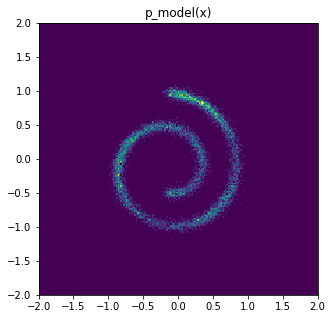

In [71]:
plt.figure(figsize=(5, 5))
plt.title('p_model(x)')
plt.hist2d(x[:,0].numpy(), x[:,1].numpy(), 200, range=((-2, 2), (-2, 2)))
# plt.axis('off')
plt.show()